## Imports and Custom Functions

In [1]:
#Imports
import tensorflow as tf
import numpy as np
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

import math
import joblib

from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

In [2]:
from pprint import pprint
def make_text_vectorization_layer(train_ds,  max_tokens=None, 
                                  split='whitespace',
                                  standardize="lower_and_strip_punctuation",
                                  output_mode="int",
                                  output_sequence_length=None,
                                  ngrams=None, pad_to_max_tokens=False,
                                  verbose=True,
                                  **kwargs,
                                 ):
    # Build the text vectorization layer
    text_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens,
        standardize=standardize, 
        output_mode=output_mode,
        output_sequence_length=output_sequence_length,
        **kwargs
    )
    # Get just the text from the training data
    if isinstance(train_ds, (np.ndarray, list, tuple, pd.Series)):
        ds_texts = train_ds
    else:
        try:
            ds_texts = train_ds.map(lambda x, y: x )
        except:
            ds_texts = train_ds
            
    # Fit the layer on the training texts
    text_vectorizer.adapt(ds_texts)
    
    
    if verbose:
        # Print the params
        print( "\ntf.keras.layers.TextVectorization(" )
        config = text_vectorizer.get_config()
        pprint(config,indent=4)
        print(")")
               
    # SAVING VOCAB FOR LATER
    # Getting list of vocab 
    vocab = text_vectorizer.get_vocabulary()
    # Save dictionaries to look up words from ints 
    int_to_str  = {idx:word for idx, word in enumerate(vocab)}
    
    return text_vectorizer, int_to_str


In [3]:
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict



In [4]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

In [5]:
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])
    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()
    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):
        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]
        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass
        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)
    # Adjust subplots and show
    fig.tight_layout()
    plt.show()

In [6]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

In [7]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs

## Load and Preprocess Data

In [8]:
df = joblib.load('Data-NLP/df_high_low_reviews-1')
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,tokens,joined_tokens,lemmas,joined_lemmas
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully...",3.0,"[underwhelmed, straight, bored, course, seeing, hunt, climb, mountain, harness, impressive, sure, liked, idea, villain, piece, angle, woefully, underdeveloped, setting, predominantly, australia, grab, attention, saying, cause, pretty, biased, com...",underwhelmed straight bored course seeing hunt climb mountain harness impressive sure liked idea villain piece angle woefully underdeveloped setting predominantly australia grab attention saying cause pretty biased comes hear tell mission impossi...,"[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell...",underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low poi...
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf...,2.0,"[entertainign, mission, impossible, second, installment, turned, terrible, screenwriters, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scenes, horrible, need, barf, bag, stand, slo, mo, seconds, 15, seconds, amazed, decide, push, m,...",entertainign mission impossible second installment turned terrible screenwriters know fill 2 hrs action overuse heroic slow motion scenes horrible need barf bag stand slo mo seconds 15 seconds amazed decide push m movies turned better hard beat l...,"[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie...",entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide push m movie turn well hard beat lousy piece ...
20,6409202f0e441900e887a17b,4234,tt0134084,Scream 3,**_Scream 3’s_ lackluster screenplay and unimaginative kills leave a film that is a bore to watch.**\r\n\r\nThe meta-narrative of trilogies throughout the film does not make up for how abysmal the plot was. This film creates so much lore for the ...,4.0,"[scream, 3, lackluster, screenplay, unimaginative, kills, leave, film, bore, watch, meta, narrative, trilogies, film, abysmal, plot, film, creates, lore, past, movies, seemingly, blue, muddling, continuity, shock, value, added, little, film, felt...",scream 3 lackluster screenplay unimaginative kills leave film bore watch meta narrative trilogies film abysmal plot film creates lore past movies seemingly blue muddling continuity shock value added little film felt forced entire plot point sidne...,"[scream, 3, lackluster, screenplay, unimaginative, kill, leave, film, bore, watch, meta, narrative, trilogy, film, abysmal, plot, film, create, lore, past, movie, seemingly, blue, muddle, continuity, shock, value, add, little, film, feel, force, ...",scream 3 lackluster screenplay unimaginative kill leave film bore watch meta narrative trilogy film abysmal plot film create lore past movie seemingly blue muddle continuity shock value add littl

In [9]:
df["rating"].isna().sum()

0

In [10]:
df_ml = df

In [11]:
def create_groups(x):
    if x<=4.0:
        return 0
    elif x >=5.0:
        return 1
    else: 
        return None

In [12]:
## Use the function to create a new "rating" column with groups
df_ml['high_low'] = df_ml['rating'].map(create_groups)
df_ml['high_low'].value_counts(dropna=False)

0    1224
1    1195
Name: high_low, dtype: int64

## Train Test Split

In [13]:
# Define X and y
X = df_ml['review']
y= df_ml["high_low"]

In [14]:
# Convert to Dataset object
ds = tf.data.Dataset.from_tensor_slices((X, y))
ds


<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [15]:
# shuffling the data once
ds = ds.shuffle(buffer_size=len(ds), reshuffle_each_iteration=False)

In [16]:
# Determing how many samples for each split
# Calculate the number of samples for training 
split_train = 0.7
n_train_samples =  int(len(ds) * split_train)
print(f"Use {n_train_samples} samples as training data")
# Calculate the number of samples for validation
split_val = 0.2
n_val_samples = int(len(ds) * split_val)
print(f"Use {n_val_samples} samples as validation data")
# Test size is remainder
split_test = 1 - (split_train + split_val)
print(f"The remaining {len(ds)- (n_train_samples+n_val_samples)} samples will be used as test data.")

Use 1693 samples as training data
Use 483 samples as validation data
The remaining 243 samples will be used as test data.


In [17]:
# Use .take to slice out the number of samples for training
train_ds = ds.take(n_train_samples)
# Skipover the training batches
val_ds = ds.skip(n_train_samples)
# Take .take to slice out the correct number of samples for validation
val_ds = val_ds.take(n_val_samples)
# Skip over all of the training + validation samples, the rest remain as samples for testing
test_ds = ds.skip(n_train_samples + n_val_samples)


In [18]:
## Shuffling just the training data  
train_ds  = train_ds.shuffle(buffer_size = len(train_ds))

In [19]:
#  Setting the batch_size for all datasets
BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')


 There are 53 training batches.
 There are 16 validation batches.
 There are 8 testing batches.


In [20]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

## Build Model

In [21]:
# Create the TextVectorization layer
count_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="count"
)


In [22]:
# Fit the layer on the training texts
model = count_vectorizer.adapt(ds_texts)

In [23]:
# Define vectorizer layer. Use the custom function to build and fit the vectorizer before using it in model
count_vectorizer, count_lookup = make_text_vectorization_layer(train_ds, output_mode='count',
                                                                        verbose=True)


tf.keras.layers.TextVectorization(
{   'batch_input_shape': (None,),
    'dtype': 'string',
    'encoding': 'utf-8',
    'idf_weights': None,
    'max_tokens': None,
    'name': 'text_vectorization_1',
    'ngrams': None,
    'output_mode': 'count',
    'output_sequence_length': None,
    'pad_to_max_tokens': False,
    'ragged': False,
    'sparse': False,
    'split': 'whitespace',
    'standardize': 'lower_and_strip_punctuation',
    'trainable': True,
    'vocabulary': None,
    'vocabulary_size': 25067}
)


In [24]:
# Check the size of the vocabulary
len(count_vectorizer.get_vocabulary())

25067

In [25]:
# Create text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=30
)
sequence_vectorizer.adapt(ds_texts)
sequence_vectorizer.vocabulary_size()


25068

In [26]:
# Obtain the sequence of sample text with the sequence_vectorizer
sequence= sequence_vectorizer(['Text Vectorization is an essential tool for converting text into a format that machine learning models can use.'])
sequence


<tf.Tensor: shape=(1, 30), dtype=int64, numpy=
array([[5256,    1,    7,   29, 2488, 6161,   17,    1, 5256,   78,    4,
        3058,   10, 1704, 6645, 8082,   62,  387,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]], dtype=int64)>

In [27]:
# Getting list of vocab
vocab = sequence_vectorizer.get_vocabulary()
int_to_str = {idx: word for idx, word in enumerate(vocab)}
int_to_str


{0: '',
 1: '[UNK]',
 2: 'the',
 3: 'and',
 4: 'a',
 5: 'of',
 6: 'to',
 7: 'is',
 8: 'it',
 9: 'in',
 10: 'that',
 11: 'i',
 12: 'this',
 13: 'but',
 14: 'was',
 15: 'with',
 16: 'as',
 17: 'for',
 18: 'movie',
 19: 'film',
 20: 'not',
 21: 'are',
 22: 'its',
 23: 'on',
 24: 'be',
 25: 'you',
 26: 'one',
 27: 'have',
 28: 'his',
 29: 'an',
 30: 'so',
 31: 'all',
 32: 'he',
 33: 'from',
 34: 'like',
 35: 'at',
 36: 'by',
 37: 'they',
 38: 'just',
 39: 'if',
 40: 'more',
 41: 'about',
 42: 'or',
 43: 'what',
 44: 'has',
 45: 'there',
 46: 'story',
 47: 'some',
 48: 'who',
 49: 'even',
 50: 'out',
 51: 'me',
 52: 'good',
 53: 'really',
 54: 'my',
 55: 'time',
 56: 'when',
 57: 'very',
 58: 'no',
 59: 'which',
 60: 'we',
 61: 'much',
 62: 'can',
 63: 'only',
 64: 'had',
 65: 'their',
 66: 'her',
 67: 'well',
 68: 'than',
 69: 'would',
 70: 'up',
 71: 'because',
 72: 'how',
 73: 'also',
 74: 'way',
 75: 'do',
 76: 'characters',
 77: 'were',
 78: 'into',
 79: 'most',
 80: 'will',
 81: 'grea

In [28]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)
# Set the batch size
BATCH_SIZE =32
import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)
print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	1693 samples 	(53 batches)
    - val:  	483 samples 	(16 batches)
    - test: 	243 samples 	(8 batches)


In [29]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [30]:
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 53 training batches.
 There are 16 validation batches.
 There are 8 testing batches.


In [31]:
# Define sequence length as a variable for future use
SEQUENCE_LENGTH = 100
# Define vectorizer layer. Use the custom function to build and fit the vectorizer before using it in model
sequence_vectorizer, vocab_lookup = make_text_vectorization_layer(train_ds, output_mode='int', output_sequence_length = SEQUENCE_LENGTH, verbose=True)


tf.keras.layers.TextVectorization(
{   'batch_input_shape': (None,),
    'dtype': 'string',
    'encoding': 'utf-8',
    'idf_weights': None,
    'max_tokens': None,
    'name': 'text_vectorization_3',
    'ngrams': None,
    'output_mode': 'int',
    'output_sequence_length': 100,
    'pad_to_max_tokens': False,
    'ragged': False,
    'sparse': False,
    'split': 'whitespace',
    'standardize': 'lower_and_strip_punctuation',
    'trainable': True,
    'vocabulary': None,
    'vocabulary_size': 25068}
)


In [32]:
# Programmatically define size of vocab from vectorization layer
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE



25068

In [33]:
# Define output dimension
EMBED_DIM = 150
EMBED_DIM



150

In [34]:
# Defining an embedding layer
embedding_layer = layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)


In [35]:
# Define classes variable
classes = y.unique()
classes

array([0, 1], dtype=int64)

In [36]:
# Define a function for building an LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
def build_lstm_model(text_vectorization_layer):
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    lstm_model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    lstm_model.add(layers.LSTM(128))
    # Add output layer
    lstm_model.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    lstm_model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    lstm_model.summary()
    return lstm_model


In [37]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]


In [38]:
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)
# Define number of epochs
EPOCHS = 30
# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 100, 150)          3760200   
                                                                 
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 3,903,306
Trainable params: 3,903,306
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
53/53 [==============================] - 6s 85ms/step - loss: 0.7318 - accuracy: 0.5434 - val_loss: 0

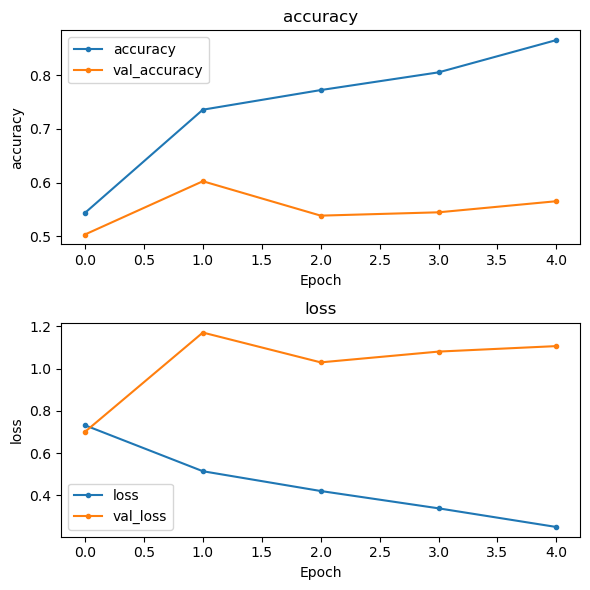


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.99      0.88       870
           1       0.98      0.72      0.83       823

    accuracy                           0.86      1693
   macro avg       0.88      0.85      0.85      1693
weighted avg       0.88      0.86      0.85      1693



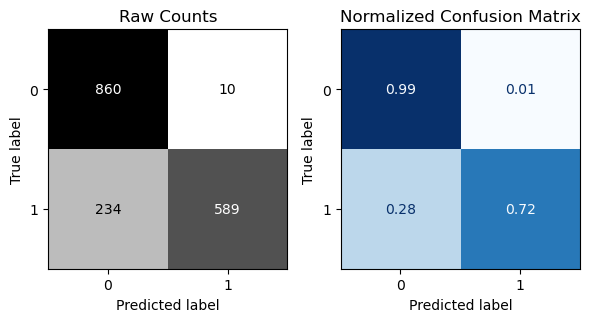


- Evaluating Training Data:
53/53 [==============================] - 1s 18ms/step - loss: 0.1931 - accuracy: 0.8559
{'loss': 0.19313029944896698, 'accuracy': 0.855877161026001}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.71      0.59       120
           1       0.53      0.32      0.40       123

    accuracy                           0.51       243
   macro avg       0.51      0.51      0.49       243
weighted avg       0.52      0.51      0.49       243



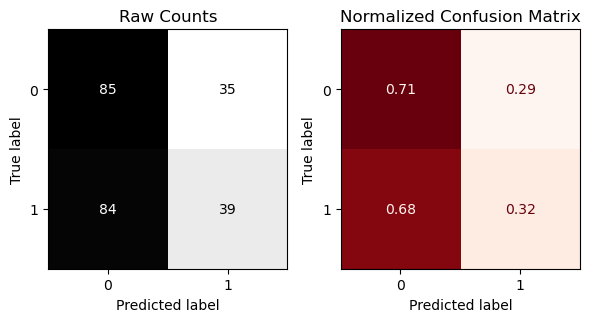


- Evaluating Test Data:
8/8 [==============================] - 0s 20ms/step - loss: 1.2494 - accuracy: 0.5103
{'loss': 1.249356746673584, 'accuracy': 0.5102880597114563}


In [39]:
# Obtain the results
evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds, history=history
);

## RNNs

In [40]:
def build_gru_model_stack_deep_pool(text_vectorization_layer):
    
    
    MAX_TOKENS = text_vectorization_layer.vocabulary_size()
        
    model = tf.keras.Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])

    # Stack three GrU layers    
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.5))
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.5))         
    # For the final GRU layer, use return_sequences = True for pooling layer
    model.add(layers.GRU(128, return_sequences = True)) 
    model.add(layers.GlobalMaxPooling1D())
    # Output layer
    model.add(layers.Dense(len(classes), 
                              activation='softmax'))

              
    # Define optimizer
    optimizer = optimizers.legacy.Adam()

    # Compile
    model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [41]:
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 100, 150)          3760200   
                                                                 
 gru (GRU)                   (None, 100, 128)          107520    
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 gru_1 (GRU)                 (None, 100, 128)          99072     
                                                                 
 dropout_1 (Dropout)         (None, 100, 128)          0         
                                                      

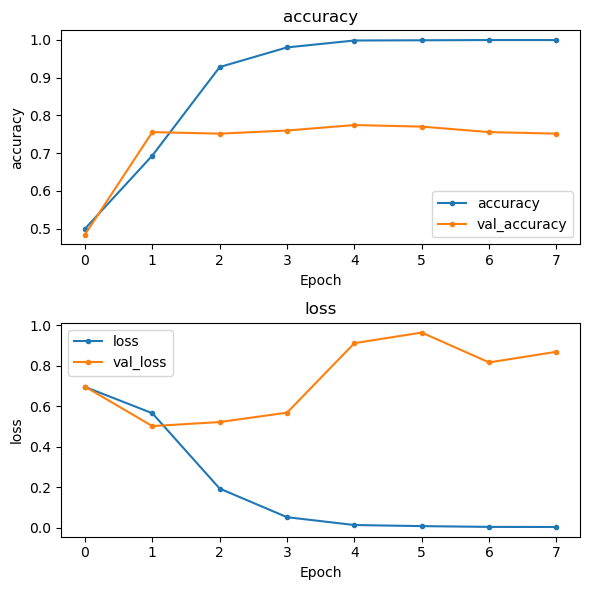


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       120
           1       0.78      0.80      0.79       123

    accuracy                           0.79       243
   macro avg       0.79      0.79      0.79       243
weighted avg       0.79      0.79      0.79       243



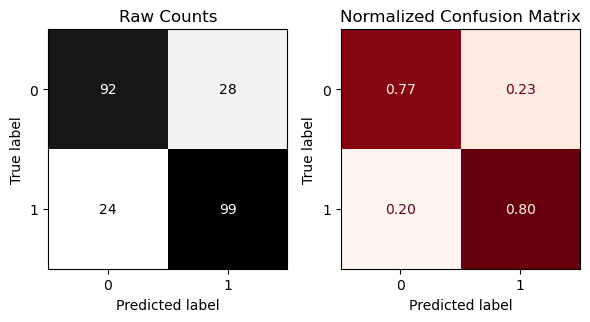


- Evaluating Test Data:
8/8 [==============================] - 0s 40ms/step - loss: 0.7625 - accuracy: 0.7860
{'loss': 0.762525200843811, 'accuracy': 0.7860082387924194}


In [42]:
# Build model
model = build_gru_model_stack_deep_pool(sequence_vectorizer)

EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
results = evaluate_classification_network(
    model,
    X_test=test_ds, history=history
);
